In [1]:
###########import packages##########
import tensorflow as tf
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras import optimizers
from keras import regularizers
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.callbacks import TensorBoard
from keras.constraints import max_norm
from keras.models import Sequential 
from keras.layers import Dense 
from keras.layers import Dropout 
from keras.models import Model
from keras.layers import BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier 
from keras.wrappers.scikit_learn import KerasRegressor
from keras.constraints import maxnorm 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import GridSearchCV
from sko.GA import GA
from sko.PSO import PSO
import time
from keras.models import Model, load_model
from sko.GA import GA
from sko.DE import DE
from sklearn import tree
from sklearn.metrics import r2_score
import pickle



In [2]:
###########assign memory##########
gpus = tf.config.experimental.list_physical_devices('GPU')  # 获取GPU列表
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    # 失效： tf.config.experimental.set_per_process_memory_fraction(0.25)
    # 第一个参数为原则哪块GPU，只有一块则是gpu[0],后面的memory_limt是限制的显存大小，单位为M
    tf.config.experimental.set_virtual_device_configuration(gpu, [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*4)]) 

early_stopping=keras.callbacks.EarlyStopping(
 monitor="val_loss", 
 patience=20, 
 verbose=0, 
 mode="auto"
)

In [3]:

database=pd.read_csv('finaldatabase.csv')


In [4]:
###########fix random seed for reproducability##########
seed=1
np.random.seed(seed)
###########wrapping root mean square error for later calls##########
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())
###########loading data##########
#fdata=pd.read_csv('database.csv',encoding="utf-8")
raw_data=database.loc[:,[                     
    'xN2a_in0',#0
    'RH_CC',#1
    'dela_CH (mm)',#2
    'dela_M (um)',#3
    'dela_GDL (um)',#4
    'p_A (atm)',#5
    'T_cc (K)',#6
    'E cell (V)',#7
    'current',#8
    'fyN2',#9
    
                    
                        ]]
###########data standardization##########
standardized_data = (raw_data-np.mean(raw_data,axis=0))/np.std(raw_data,axis=0)

###########defining a wrapper function for later call from each machine learning algorithms##########
raw_input=standardized_data.iloc[:,0:8]
raw_output=standardized_data.iloc[:,8:]
X=raw_input.values.astype(np.float32)
y=raw_output.values.astype(np.float32)
###########fix random seed for reproducability##########
seed=1
###########train test splitting##########
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.15,random_state=seed)
raw_input_global=raw_data.iloc[:,0:8]
raw_output_global=raw_data.iloc[:,8:]
###########wrap up fuction for later call for OPTIMIZATION##########
def evaluate(pre_2,real_2):
    pre_2=np.array(pre_2)
    real_2=np.array(real_2)
    pre_2_series=pd.Series(pre_2)
    real_2_series=pd.Series(real_2)
    return rmse(pre_2,real_2), round(pre_2_series.corr(real_2_series), 3)
def compare(list_name,limit):
    judge=1
    for a in list_name:
        if a < limit:
            judge=judge*1
        else:
            judge=judge*0
    return judge
def generate_arrays_from_file(path):
    while True:
        with open(path) as f:
            for line in f:
                # create numpy arrays of input data
                # and labels, from each line in the file
                x1, x2, y = process_line(line)
                yield ({'input_1': x1, 'input_2': x2}, {'output': y})
neurons1=500
regularizer=keras.regularizers.l2(0)
dropout_rate=0
epochs_number=1000
learning_rate_search=0.000005
batch_size_number=32
activation1='relu'
###########keras ANN model construction##########
model = Sequential() 
model.add(Dense(neurons1, input_dim=8, kernel_initializer='random_normal',
                bias_initializer='random_normal',activation=activation1,kernel_regularizer=regularizer)) 
model.add(Dropout(dropout_rate))
model.add(Dense(neurons1, input_dim=neurons1, kernel_initializer='random_normal',
                bias_initializer='random_normal',activation=activation1,kernel_regularizer=regularizer)) 
model.add(Dropout(dropout_rate))
model.add(Dense(2, input_dim=neurons1, activation='linear'))
#adam=optimizers.Adam(lr=learning_rate_search)
model.compile(loss='mse')
print('training...')
t1=time.time()
model.fit(X_train, y_train,verbose=1, batch_size=batch_size_number,epochs=epochs_number)
dt_ANN=time.time()-t1


training...
Epoch 1/1000
217/217 [==============================] - 2s 2ms/step - loss: 0.0429
Epoch 2/1000
217/217 [==============================] - 1s 2ms/step - loss: 0.0125
Epoch 3/1000
217/217 [==============================] - 1s 2ms/step - loss: 0.0092
Epoch 4/1000
217/217 [==============================] - 1s 2ms/step - loss: 0.0073
Epoch 5/1000
217/217 [==============================] - 1s 2ms/step - loss: 0.0061
Epoch 6/1000
217/217 [==============================] - 1s 2ms/step - loss: 0.0053
Epoch 7/1000
217/217 [==============================] - 1s 2ms/step - loss: 0.0048
Epoch 8/1000
217/217 [==============================] - 1s 2ms/step - loss: 0.0043
Epoch 9/1000
217/217 [==============================] - 1s 2ms/step - loss: 0.0040
Epoch 10/1000
217/217 [==============================] - 1s 2ms/step - loss: 0.0037
Epoch 11/1000
217/217 [==============================] - 1s 2ms/step - loss: 0.0033
Epoch 12/1000
217/217 [==============================] - 1s 2ms/step - lo

Epoch 97/1000
217/217 [==============================] - 1s 2ms/step - loss: 8.2882e-04
Epoch 98/1000
217/217 [==============================] - 1s 2ms/step - loss: 7.8934e-04
Epoch 99/1000
217/217 [==============================] - 1s 2ms/step - loss: 7.9819e-04
Epoch 100/1000
217/217 [==============================] - 1s 2ms/step - loss: 7.9550e-04
Epoch 101/1000
217/217 [==============================] - 1s 2ms/step - loss: 7.8324e-04
Epoch 102/1000
217/217 [==============================] - 1s 2ms/step - loss: 7.8771e-04
Epoch 103/1000
217/217 [==============================] - 1s 2ms/step - loss: 7.7606e-04
Epoch 104/1000
217/217 [==============================] - 1s 2ms/step - loss: 7.4896e-04
Epoch 105/1000
217/217 [==============================] - 0s 2ms/step - loss: 7.6346e-04
Epoch 106/1000
217/217 [==============================] - 1s 2ms/step - loss: 7.5508e-04
Epoch 107/1000
217/217 [==============================] - 1s 2ms/step - loss: 7.8060e-04
Epoch 108/1000
217/217 [

217/217 [==============================] - 0s 2ms/step - loss: 5.0514e-04
Epoch 190/1000
217/217 [==============================] - 0s 2ms/step - loss: 5.4793e-04
Epoch 191/1000
217/217 [==============================] - 1s 2ms/step - loss: 4.9743e-04
Epoch 192/1000
217/217 [==============================] - 0s 2ms/step - loss: 5.2268e-04
Epoch 193/1000
217/217 [==============================] - 1s 2ms/step - loss: 4.9443e-04
Epoch 194/1000
217/217 [==============================] - 1s 2ms/step - loss: 5.0985e-04
Epoch 195/1000
217/217 [==============================] - 1s 2ms/step - loss: 4.9701e-04
Epoch 196/1000
217/217 [==============================] - 1s 2ms/step - loss: 5.3255e-04
Epoch 197/1000
217/217 [==============================] - 1s 2ms/step - loss: 5.0430e-04
Epoch 198/1000
217/217 [==============================] - 1s 2ms/step - loss: 5.1700e-04
Epoch 199/1000
217/217 [==============================] - 1s 2ms/step - loss: 5.2068e-04
Epoch 200/1000
217/217 [============

217/217 [==============================] - 1s 2ms/step - loss: 3.5496e-04
Epoch 374/1000
217/217 [==============================] - 1s 2ms/step - loss: 3.4971e-04
Epoch 375/1000
217/217 [==============================] - 1s 2ms/step - loss: 3.3587e-04
Epoch 376/1000
217/217 [==============================] - 1s 2ms/step - loss: 3.4534e-04
Epoch 377/1000
217/217 [==============================] - 1s 2ms/step - loss: 3.6260e-04
Epoch 378/1000
217/217 [==============================] - 1s 2ms/step - loss: 3.5365e-04
Epoch 379/1000
217/217 [==============================] - 1s 2ms/step - loss: 3.5062e-04
Epoch 380/1000
217/217 [==============================] - 1s 2ms/step - loss: 3.4365e-04
Epoch 381/1000
217/217 [==============================] - 1s 2ms/step - loss: 3.4333e-04
Epoch 382/1000
217/217 [==============================] - 1s 2ms/step - loss: 3.3850e-04
Epoch 383/1000
217/217 [==============================] - 1s 2ms/step - loss: 3.4698e-04
Epoch 384/1000
217/217 [============

Epoch 465/1000
217/217 [==============================] - 1s 2ms/step - loss: 3.2019e-04
Epoch 466/1000
217/217 [==============================] - 1s 2ms/step - loss: 3.1619e-04
Epoch 467/1000
217/217 [==============================] - 1s 2ms/step - loss: 3.1122e-04
Epoch 468/1000
217/217 [==============================] - 1s 2ms/step - loss: 3.2282e-04
Epoch 469/1000
217/217 [==============================] - 1s 2ms/step - loss: 3.0561e-04
Epoch 470/1000
217/217 [==============================] - 1s 2ms/step - loss: 3.1789e-04
Epoch 471/1000
217/217 [==============================] - 1s 2ms/step - loss: 3.1422e-04
Epoch 472/1000
217/217 [==============================] - 1s 2ms/step - loss: 3.0737e-04
Epoch 473/1000
217/217 [==============================] - 1s 2ms/step - loss: 3.1126e-04
Epoch 474/1000
217/217 [==============================] - 1s 2ms/step - loss: 3.1541e-04
Epoch 475/1000
217/217 [==============================] - 1s 2ms/step - loss: 3.1587e-04
Epoch 476/1000
217/21

217/217 [==============================] - 1s 2ms/step - loss: 2.9912e-04
Epoch 558/1000
217/217 [==============================] - 1s 2ms/step - loss: 2.9320e-04
Epoch 559/1000
217/217 [==============================] - 1s 2ms/step - loss: 2.9152e-04
Epoch 560/1000
217/217 [==============================] - 1s 2ms/step - loss: 2.9204e-04
Epoch 561/1000
217/217 [==============================] - 1s 2ms/step - loss: 2.9656e-04
Epoch 562/1000
217/217 [==============================] - 1s 2ms/step - loss: 2.9067e-04
Epoch 563/1000
217/217 [==============================] - 1s 2ms/step - loss: 2.9745e-04
Epoch 564/1000
217/217 [==============================] - 1s 2ms/step - loss: 2.9061e-04
Epoch 565/1000
217/217 [==============================] - 1s 2ms/step - loss: 2.9143e-04
Epoch 566/1000
217/217 [==============================] - 1s 2ms/step - loss: 2.9280e-04
Epoch 567/1000
217/217 [==============================] - 1s 2ms/step - loss: 2.9414e-04
Epoch 568/1000
217/217 [============

217/217 [==============================] - 1s 2ms/step - loss: 2.7085e-04
Epoch 650/1000
217/217 [==============================] - 1s 2ms/step - loss: 2.7786e-04
Epoch 651/1000
217/217 [==============================] - 1s 2ms/step - loss: 2.8145e-04
Epoch 652/1000
217/217 [==============================] - 1s 2ms/step - loss: 2.6894e-04
Epoch 653/1000
217/217 [==============================] - 0s 2ms/step - loss: 2.7034e-04
Epoch 654/1000
217/217 [==============================] - 1s 2ms/step - loss: 2.7579e-04
Epoch 655/1000
217/217 [==============================] - 1s 2ms/step - loss: 2.6747e-04
Epoch 656/1000
217/217 [==============================] - 1s 2ms/step - loss: 2.6929e-04
Epoch 657/1000
217/217 [==============================] - 1s 2ms/step - loss: 2.7595e-04
Epoch 658/1000
217/217 [==============================] - 1s 2ms/step - loss: 2.6404e-04
Epoch 659/1000
217/217 [==============================] - 1s 2ms/step - loss: 2.6381e-04
Epoch 660/1000
217/217 [============

217/217 [==============================] - 1s 2ms/step - loss: 2.5153e-04
Epoch 833/1000
217/217 [==============================] - 1s 2ms/step - loss: 2.4661e-04
Epoch 834/1000
217/217 [==============================] - 1s 2ms/step - loss: 2.3936e-04
Epoch 835/1000
217/217 [==============================] - 1s 2ms/step - loss: 2.4971e-04A: 0s - loss: 3.
Epoch 836/1000
217/217 [==============================] - 1s 2ms/step - loss: 2.4602e-04
Epoch 837/1000
217/217 [==============================] - 0s 2ms/step - loss: 2.3745e-04
Epoch 838/1000
217/217 [==============================] - 1s 2ms/step - loss: 2.4211e-04
Epoch 839/1000
217/217 [==============================] - 1s 2ms/step - loss: 2.4612e-04
Epoch 840/1000
217/217 [==============================] - 1s 2ms/step - loss: 2.4016e-04
Epoch 841/1000
217/217 [==============================] - 1s 2ms/step - loss: 2.4353e-04
Epoch 842/1000
217/217 [==============================] - 1s 2ms/step - loss: 2.4796e-04
Epoch 843/1000
217/2

scatter p_corr  0.9999 scatter p_rmse  0.007490367126901137 scatter p_r2  0.9998


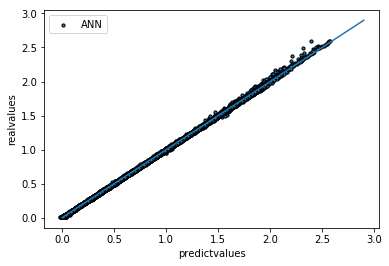

scatter v_corr  0.99992 scatter v_rmse  5.488810886808279e-18 scatter v_r2  0.99981


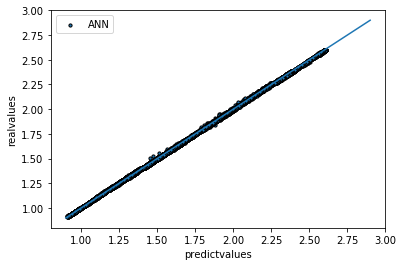

In [5]:
print('time consumption:',dt_ANN)
result=model.predict(X)
lpredictvalues=np.std(raw_output_global,axis=0).T.values*result+np.mean(raw_output_global,axis=0).T.values
lrealvalues=np.std(raw_output_global,axis=0).T.values*y+np.mean(raw_output_global,axis=0).T.values
spredictvalues_power=pd.Series(lpredictvalues[:,0])
srealvalues_power=pd.Series(lrealvalues[:,0])
current_corr=round(spredictvalues_power.corr(srealvalues_power), 5)
current_rmse=rmse(lpredictvalues[:,0],lrealvalues[:,0])
current_r2 = round(r2_score(lpredictvalues[:,0],lrealvalues[:,0]), 5)
print('scatter current_corr ',current_corr,'scatter current_rmse ',current_rmse,'scatter current_r2 ',current_r2)
x_y_x=np.arange(0,3,0.1)
x_y_y=np.arange(0,3,0.1)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(lpredictvalues[:,0],lrealvalues[:,0],edgecolor='black',s=10,label='ANN')
ax.plot(x_y_x,x_y_y)
plt.legend()
plt.xlabel(u"predictvalues")
plt.ylabel(u"realvalues")
plt.show()

spredictvalues_velocity=pd.Series(lpredictvalues[:,1])
srealvalues_velocity=pd.Series(lrealvalues[:,1])
crossover_rate_corr=round(spredictvalues_velocity.corr(srealvalues_velocity), 5)
crossover_rate_rmse=rmse(lpredictvalues[:,1],lrealvalues[:,1])
crossover_rate_r2 = round(r2_score(lpredictvalues[:,1],lrealvalues[:,1]), 5)
print('scatter crossover_rate_corr ',crossover_rate_corr,'scatter crossover_rate_rmse ',crossover_rate_rmse,'scatter crossover_rate_r2 ',crossover_rate_r2)
x_y_x=np.arange(9e-16,3e-15,1e-16)
x_y_y=np.arange(9e-16,3e-15,1e-16)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(lpredictvalues[:,1]*1e15,lrealvalues[:,1]*1e15,edgecolor='black',s=10,label='ANN')
ax.plot(x_y_x*1e15,x_y_y*1e15)
plt.legend()
plt.xlabel(u"predictvalues")
plt.ylabel(u"realvalues")
plt.show()

In [85]:
model.save('ann.h5')